In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
# print(os.listdir("../input"))

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm

from scipy.stats import skew

sns.set(style='white', context='notebook', palette='deep')



# Any results you write to the current directory are saved as output.

**Importing the dataset**


In [40]:
dataset = pd.read_csv('real_estate.csv')
dataset.head()

/Users/agesp/.brew/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (18,19,20,21,22,23,24,33,34,35,37,43,45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,...,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,X,Y,QUADRANT
0,0,4,0,Warm Cool,Y,2.0,8,4,1910.0,1988.0,...,-77.040832,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
1,1,3,1,Warm Cool,Y,2.0,11,5,1898.0,2007.0,...,-77.040764,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
2,2,3,1,Hot Water Rad,Y,2.0,9,5,1910.0,2009.0,...,-77.040678,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
3,3,3,1,Hot Water Rad,Y,2.0,8,5,1900.0,2003.0,...,-77.040629,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
4,4,2,1,Warm Cool,Y,1.0,11,3,1913.0,2012.0,...,-77.039361,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW


**a.	Split the data into 3 parts – training_data, test_data and unknown_data**

In [41]:
#dataset.isnull().sum()

dummy_dataset = dataset

dummy_dataset['Price_Flag'] = np.where(dummy_dataset.PRICE > 0 , 1,0)

unknown_dataset = dummy_dataset[dummy_dataset.Price_Flag != 1]

unknown_dataset.shape

(60741, 50)

In [42]:
from sklearn.model_selection import train_test_split

dataset = dummy_dataset[dummy_dataset.Price_Flag != 0]


**Data Cleaning and Handling Outliers**

In [43]:
dataset = dataset.drop(['Price_Flag','X','Y','CMPLX_NUM','FULLADDRESS','LONGITUDE','CITY','STATE','NATIONALGRID','CENSUS_BLOCK','SALEDATE','QUADRANT'],axis=1)

dataset.GBA = dataset.GBA.fillna(dataset.GBA.mean())

dataset.AYB = dataset.AYB.fillna(dataset.AYB.median())

dataset.STORIES = dataset.STORIES.fillna(dataset.STORIES.median())

dataset.KITCHENS = dataset.KITCHENS.fillna(dataset.KITCHENS.median())

dataset.NUM_UNITS = dataset.NUM_UNITS.fillna(dataset.NUM_UNITS.median())

dataset.YR_RMDL = dataset.YR_RMDL.fillna(dataset.YR_RMDL.median())

dataset.LIVING_GBA = dataset.LIVING_GBA.fillna(dataset.LIVING_GBA.mean())

dataset.STYLE = dataset.STYLE.fillna(dataset.STYLE.mode()[0])

dataset.STRUCT = dataset.STRUCT.fillna(dataset.STRUCT.mode()[0])

dataset.GRADE = dataset.GRADE.fillna(dataset.GRADE.mode()[0])

dataset.CNDTN = dataset.CNDTN.fillna(dataset.CNDTN.mode()[0])

dataset.EXTWALL = dataset.EXTWALL.fillna(dataset.EXTWALL.mode()[0])

dataset.ROOF = dataset.ROOF.fillna(dataset.ROOF.mode()[0])

dataset.INTWALL = dataset.INTWALL.fillna(dataset.INTWALL.mode()[0])

dataset.ASSESSMENT_SUBNBHD  = dataset.ASSESSMENT_SUBNBHD.fillna(dataset.ASSESSMENT_SUBNBHD.mode()[0])

dataset.isnull().sum()



Unnamed: 0            0
BATHRM                0
HF_BATHRM             0
HEAT                  0
AC                    0
NUM_UNITS             0
ROOMS                 0
BEDRM                 0
AYB                   0
YR_RMDL               0
EYB                   0
STORIES               0
PRICE                 0
QUALIFIED             0
SALE_NUM              0
GBA                   0
BLDG_NUM              0
STYLE                 0
STRUCT                0
GRADE                 0
CNDTN                 0
EXTWALL               0
ROOF                  0
INTWALL               0
KITCHENS              0
FIREPLACES            0
USECODE               0
LANDAREA              0
GIS_LAST_MOD_DTTM     0
SOURCE                0
LIVING_GBA            0
ZIPCODE               0
LATITUDE              0
ASSESSMENT_NBHD       0
ASSESSMENT_SUBNBHD    0
CENSUS_TRACT          0
WARD                  0
SQUARE                0
dtype: int64

**Splitting the dataset to Test and Train after Cleaning and Data Handling**

In [44]:
train_dataset = dataset

train_dataset = train_dataset.drop('Unnamed: 0',axis =1)

cat = len(train_dataset.select_dtypes(include=['object']).columns)
num = len(train_dataset.select_dtypes(include=['int64','float64']).columns)
print('Total Features: ', cat, 'categorical', '+',
      num, 'numerical', '=', cat+num, 'features')

Total Features:  16 categorical + 21 numerical = 37 features


1. **With 39 features, we cant possibly tell which feature is most related to house prices. so we find the correlation of the Price of the house with every other variables**

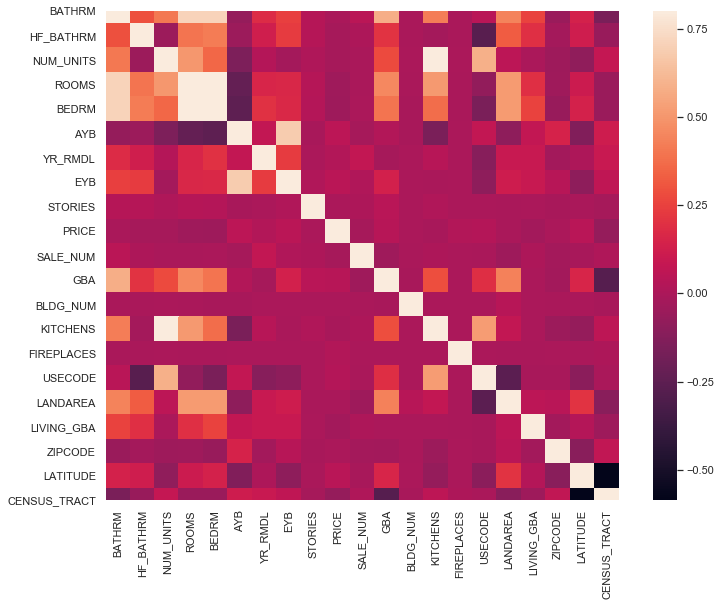

In [45]:
corrmat = train_dataset.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

**Finding the top 10 Independent factors that contribute to the Price of the house**

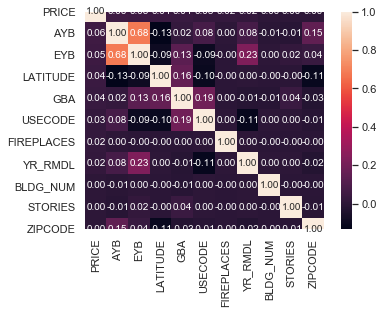

In [46]:
k = 11 #number of variables for heatmap
cols = corrmat.nlargest(k, 'PRICE')['PRICE'].index
cm = np.corrcoef(train_dataset[cols].values.T)
sns.set(font_scale=1.00)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [47]:
most_corr = pd.DataFrame(cols)
most_corr.columns = ['Most Correlated Features']
most_corr

,Most Correlated Features
0,PRICE
1,AYB
2,EYB
3,LATITUDE
4,GBA
5,USECODE
6,FIREPLACES
7,YR_RMDL
8,BLDG_NUM
9,STORIES


**The above are the list of Top  Variables (Independent Factors) with postive correlation to the house price that contribute to the Price of the house**

GBA -  Gross building area in square feet

AYB - The earliest time the main portion of the building was built

EYB - The year an improvement was built more recent than actual year built

Latitude - The location of the propert

Kitchens - Number of kitchens

Stories - Number of stories in primary dwelling

Yr_Model - Year structure was remodeled



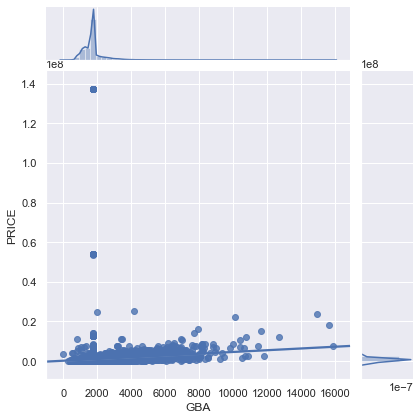

In [48]:
# Gross Building Area vs  Price

sns.jointplot(x=train_dataset['GBA'], y=train_dataset['PRICE'], kind='reg')

**It makes sense that people would pay for the more living area. **

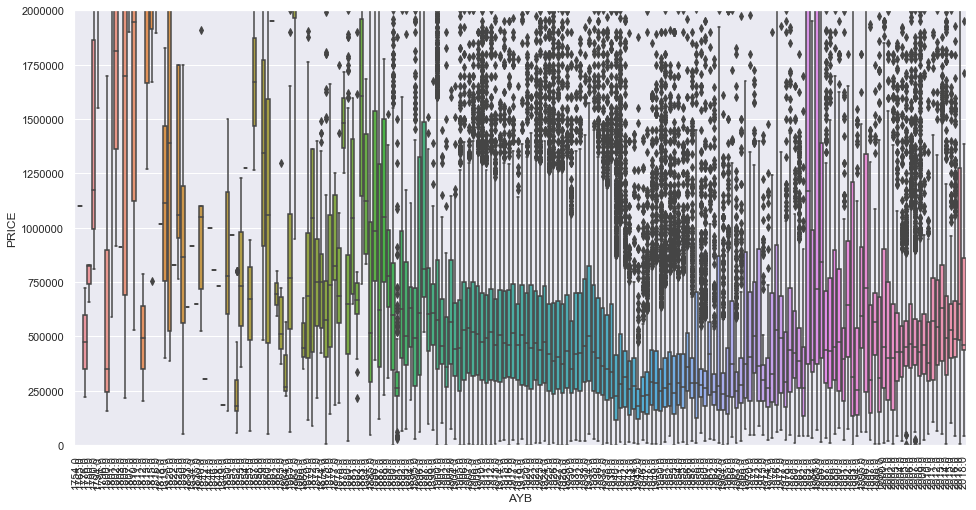

In [49]:
# AYB vs  Price

var = 'AYB'
data = pd.concat([train_dataset['PRICE'], train_dataset[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="PRICE", data=data)
fig.axis(ymin=0, ymax=2000000);
plt.xticks(rotation=90);

**We cant come to any probable conclusion between age of the house and the Price of the house with this boxplot**

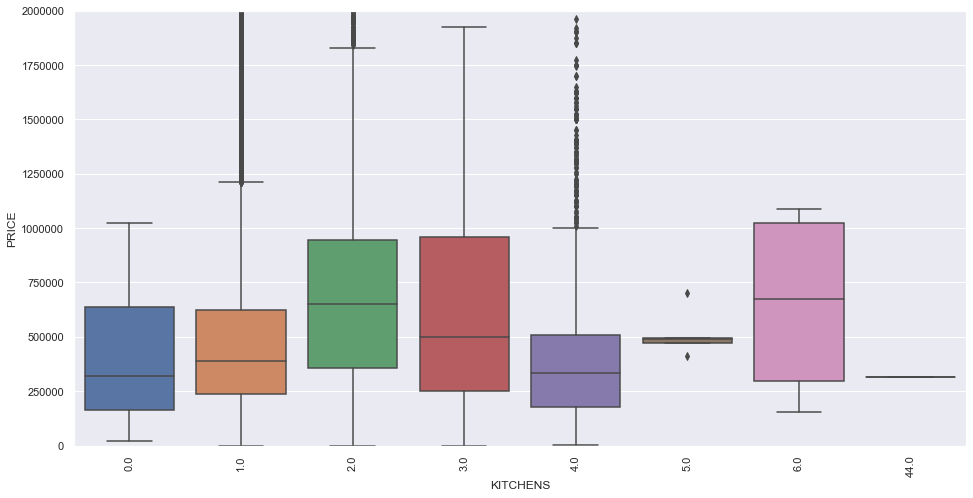

In [50]:
# Kitchens vs  Price

var = 'KITCHENS'
data = pd.concat([train_dataset['PRICE'], train_dataset[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="PRICE", data=data)
fig.axis(ymin=0, ymax=2000000);
plt.xticks(rotation=90);

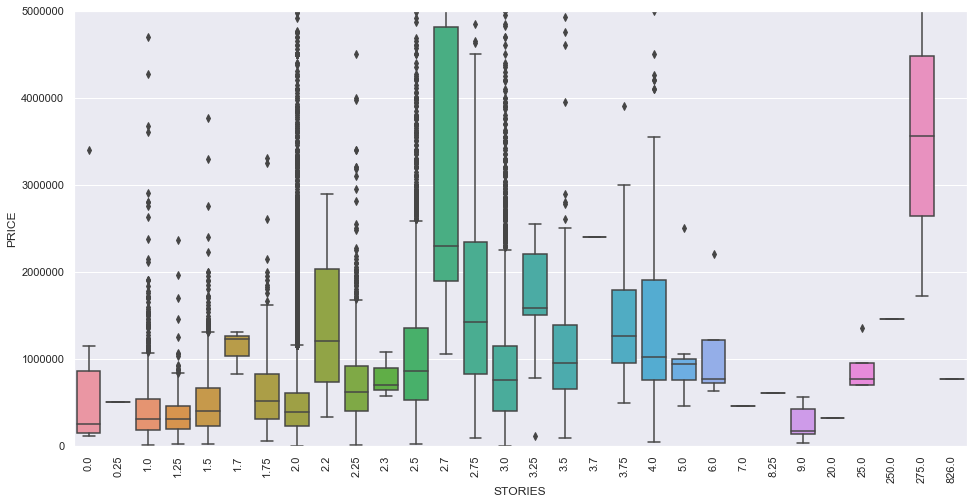

In [51]:
# Stories vs  Price

var = 'STORIES'
data = pd.concat([train_dataset['PRICE'], train_dataset[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="PRICE", data=data)
fig.axis(ymin=0, ymax=5000000);
plt.xticks(rotation=90);

**Labelling the Categorical Data**

In [52]:
from sklearn.preprocessing import LabelEncoder
cols = train_dataset.select_dtypes(include=['object']).columns
# Process columns and apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(train_dataset[c].values)) 
    train_dataset[c] = lbl.transform(list(train_dataset[c].values))

train_dataset.head()

,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,...,GIS_LAST_MOD_DTTM,SOURCE,LIVING_GBA,ZIPCODE,LATITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,WARD,SQUARE
0,4,0,12,2,2.0,8,4,1910.0,1988.0,1972,...,1,1,882.090907,20009.0,38.914680,42,92,4201.0,1,417
2,3,1,7,2,2.0,9,5,1910.0,2009.0,1984,...,1,1,882.090907,20009.0,38.914684,42,92,4201.0,1,417
3,3,1,7,2,2.0,8,5,1900.0,2003.0,1984,...,1,1,882.090907,20009.0,38.914683,42,92,4201.0,1,417
5,3,2,7,2,1.0,10,5,1913.0,2005.0,1972,...,1,1,882.090907,20009.0,38.914331,42,92,4201.0,1,417
7,3,1,7,2,2.0,8,4,1906.0,2011.0,1972,...,1,1,882.090907,20009.0,38.915408,42,92,4201.0,1,417


**Finding the Skewness of the Data**


 mu = 931351.59 and sigma = 7061289.01



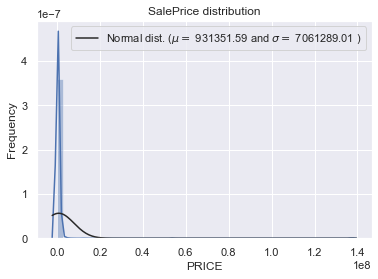

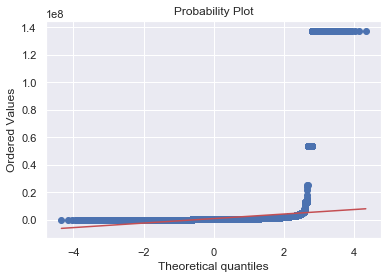

Skewness: 18.316249
Kurtosis: 344.901941


In [53]:
# We use the numpy fuction log which  applies log to all elements of the column
# train_dataset["PRICE"] = np.exp(train_dataset["PRICE"])

#Check the new distribution 
sns.distplot(train_dataset['PRICE'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_dataset['PRICE'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train_dataset['PRICE'], plot=plt)
plt.show()

y_train = train_dataset.PRICE.values

print("Skewness: %f" % train_dataset['PRICE'].skew())
print("Kurtosis: %f" % train_dataset['PRICE'].kurt())

In [54]:
train_dataset = (train_dataset - train_dataset.mean()) / (train_dataset.max() - train_dataset.min())

In [55]:
train_dataset = pd.get_dummies(train_dataset)
print(train_dataset.shape)

(98216, 37)


In [56]:
train_dataset, test_dataset = train_test_split(train_dataset, test_size=0.2)

train_dataset.shape

(78572, 37)

**Running OLS on the Train Dataset**

In [57]:
import statsmodels.api as sm

from sklearn.metrics import r2_score

from sklearn.metrics import mean_squared_error

train_dataset_Y = train_dataset.PRICE.values

train_dataset_X = train_dataset.drop('PRICE',axis =1)

train_dataset_X.shape

train_dataset_X = sm.add_constant(train_dataset_X)

Pricing_model = sm.OLS(train_dataset_Y,train_dataset_X)

result = Pricing_model.fit()

print(train_dataset_Y)

print(result.summary())



print("RMSE: ",np.sqrt(mean_squared_error(result.fittedvalues,train_dataset_Y)))

/Users/agesp/.brew/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


[-0.00470935  0.0274228  -0.00475779 ... -0.00321152 -0.0057947
  0.01286968]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     99.05
Date:                Wed, 31 Jul 2019   Prob (F-statistic):               0.00
Time:                        16:07:40   Log-Likelihood:             1.2360e+05
No. Observations:               78572   AIC:                        -2.471e+05
Df Residuals:                   78535   BIC:                        -2.468e+05
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

In [58]:
w
test_dataset_Y = test_dataset.PRICE.values

test_dataset = test_dataset.drop('PRICE',axis=1)

predictions = result.predict(sm.add_constant(test_dataset))

RMSE = np.sqrt(mean_squared_error(predictions,test_dataset_Y))

print('The RMSE of the predicted values is ',RMSE)



NameError: name 'w' is not defined

In [ ]:
plt.scatter(test_dataset_Y, predictions)

plt.legend()
plt.title('OLS predicted values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

**Ridge Regression**

In [ ]:
from sklearn.linear_model import Ridge

from sklearn.linear_model import RidgeCV

from sklearn.metrics import r2_score

## training the model

train_dataset_X = train_dataset_X.drop('const',axis=1)

regr_cv = RidgeCV(alphas=[0.1,1,2,3,4,5,6,7,0.5,0.8])

model_cv = regr_cv.fit(train_dataset_X,train_dataset_Y)

model_cv.alpha_


In [59]:
ridgeReg = Ridge(alpha=5, normalize=True)

ridgeReg.fit(train_dataset_X,train_dataset_Y)

pred = ridgeReg.predict(test_dataset)

# calculating mse

mse = np.sqrt(mean_squared_error(pred , test_dataset_Y))

print("The Root mean square error of Ridge Regression is ", mse)

print("The R2 value of Ridge Regression is ",r2_score(test_dataset_Y,pred))

print(ridgeReg.score(train_dataset_X, train_dataset_Y))

The Root mean square error of Ridge Regression is  0.04806886857041861
The R2 value of Ridge Regression is  -0.009889305239953794
0.012789164052297353


**
Lasso Regression**

In [ ]:
from sklearn.linear_model import Lasso

lassoReg = Lasso(alpha=20, normalize=True)

lassoReg.fit(train_dataset_X,train_dataset_Y)

pred = lassoReg.predict(test_dataset)

# calculating mse

rmse = np.sqrt(mean_squared_error(pred, test_dataset_Y))

print("The Root mean square error of Lasso Regression is ", rmse)

print("The R2 value of Lasso Regression is ",r2_score(test_dataset_Y,pred))

lassoReg.score(test_dataset,test_dataset_Y)



**Decision Tree Regression**

In [ ]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state = 0)
regressor.fit(train_dataset_X,train_dataset_Y)
 
# Predicting a new result
y_pred = regressor.predict(test_dataset)

rmse = np.sqrt(mean_squared_error(y_pred, test_dataset_Y))

print("The Root mean square error of Decision Tree Regression is ", rmse)

print("The R2 value of Decision Tree Regression is ",r2_score(test_dataset_Y,y_pred))




**Weighted KNN for Regression**

In [ ]:
from sklearn import neighbors


knn = neighbors.KNeighborsRegressor(5)

pred_test = knn.fit(train_dataset_X,train_dataset_Y).predict(test_dataset)

RMSE = np.sqrt(mean_squared_error(test_dataset_Y, pred_test))

print("The Root Mean Squared Error of KNN Regression is ",RMSE)

print("The R2 value of KNN Regression is ",r2_score(test_dataset_Y,pred_test))

**Support Vector Machine Regression**

In [ ]:
# from sklearn.svm import SVR

# svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)

# svr_lin = SVR(kernel='linear', C=1e3)

# svr_poly = SVR(kernel='poly', C=1e3, degree=3)

# y_rbf = svr_rbf.fit(train_dataset_X,train_dataset_Y).predict(test_dataset)

# y_lin = svr_lin.fit(train_dataset_X,train_dataset_Y).predict(test_dataset)

# y_poly = svr_poly.fit(train_dataset_X,train_dataset_Y).predict(test_dataset)

# RMSE_1 = np.sqrt(mean_squared_error(test_dataset_Y, y_rbf))

# print("The Root Mean Squared Error of SVM (Radial Basis Function) Regression is ",RMSE_1)

# print("The R2 value of SVM (Radial Basis Function) Regression is ",r2_score(test_dataset_Y,y_rbf))

# RMSE_2 = np.sqrt(mean_squared_error(test_dataset_Y, y_lin))

# print("The Root Mean Squared Error of SVM(Linear) Regression is ",RMSE_2)

# print("The R2 value of SVM(Linear) Regression is ",r2_score(test_dataset_Y,y_lin))

# RMSE_3 = np.sqrt(mean_squared_error(test_dataset_Y, y_poly))

# print("The Root Mean Squared Error of SVM(Polynomial) Regression is ",RMSE_3)

# print("The R2 value of SVM(Polynomial) Regression is ",r2_score(test_dataset_Y,y_poly))

**Random Forest Regression**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 25)
# Train the model on training data
pred = rf.fit(train_dataset_X,train_dataset_Y).predict(test_dataset)

RMSE_1 = np.sqrt(mean_squared_error(test_dataset_Y, pred))

print("The Root Mean Squared Error of Random Forest Regression is ",RMSE_1)

print("The R2 value of Random Forest Regression is ",r2_score(test_dataset_Y,pred))

**Gradient Boosting Trees**

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

pred = GradientBoostingRegressor(n_estimators=100, learning_rate=0.3,max_depth=1, random_state=0, loss='ls').fit(train_dataset_X,train_dataset_Y).predict(test_dataset)

RMSE_1 = np.sqrt(mean_squared_error(test_dataset_Y, pred))

print("The Root Mean Squared Error of Gradient Boosting Regression is ",RMSE_1)

print("The R2 value of Gradient Boosting Regression is ",r2_score(test_dataset_Y,pred))